In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [6]:
%store -r X_motion_CoM_acc_absolute
%store -r Y_motion_CoM_acc_absolute
print(X_motion_CoM_acc_absolute.shape)
print(Y_motion_CoM_acc_absolute.shape, "\n")

%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous
print(X_motion_CoM_continuous.shape)
print(Y_motion_CoM_continuous.shape, "\n")

X_motion_CoM = np.vstack((X_motion_CoM_acc_absolute, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acc_absolute, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape, "\n")

(9780, 28)
(9780, 2) 

(10027, 28)
(10027, 2) 

(19807, 28)
(19807, 2) 



# Multivariate Linear Regression (Foot prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, 21] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [10]:
idx_fl_rr_swinging.shape

(9897,)

## Predict CoM -> x

In [11]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, -0.10000000149011612, 0.0322352146407956,
       -0.16707049163546253, 0.01633024113261936, -0.050864724772716724,
       0.01613139346307927, -0.08244774950818047, 0.2242183589315502,
       0.21463290253635245, -0.4047964527433376, 0.23125327710299393,
       -0.1859196351448079, -0.40580275730170523, -0.25716170429661755,
       0.1535668459650834, -0.40042184496154315, -0.2596469020780039,
       -0.1333438735060659, -0.4003938266901496, True, False, False, True,
       0.0, 0.0, 0.0], dtype=object)

In [12]:
Y_motion_CoM_FL_RR[0, :]

array([-0.0014475170967571671, 0.022369409865341083], dtype=object)

### Linear Regression

In [25]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 3:9], # Odom velocities
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9594869365390212
RMSE:  0.008225364278064713
The lowest error is:  1.015361577708096e-05
The highest error is:  0.05829642921528623
The avg. error is:  0.005048509995334673


In [26]:
model_fl_com_x.coef_

array([[ 0.05382383,  0.09897607,  0.03184289,  0.06121358, -0.00791956,
        -0.02725518,  0.00960227,  0.00428043,  0.0198472 ,  0.00839921,
         0.03233054, -0.06426495,  0.10890721, -0.36210346,  0.2459859 ,
        -0.7463066 ,  0.19784956, -0.37908429,  0.01378109, -0.00510437]])

In [27]:
model_fl_com_x.intercept_

array([-0.03184326])

Text(0, 0.5, 'Predictions')

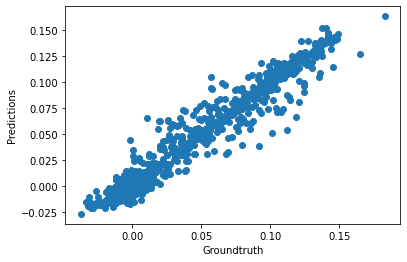

In [28]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [16]:
#%store model_fl_com_x

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [18]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM foot -> y

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, 3:9],
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9967303885463294
RMSE:  0.0019330374792168085
The lowest error is:  2.7959981813152623e-07
The highest error is:  0.01872054563041059
The avg. error is:  0.0011788905039114366


In [21]:
model_fl_com_y.coef_

array([[ 0.01939952,  0.19791707,  0.06853025, -0.00293183, -0.00139501,
         0.09252725, -0.00430708, -0.01511418, -0.10190888,  0.0490056 ,
         0.14634935, -0.08035402, -0.13057737, -0.08982922, -0.01685321,
        -0.05255996,  0.30740592]])

In [22]:
model_fl_com_y.intercept_

array([-0.02129322])

Text(0, 0.5, 'Predictions')

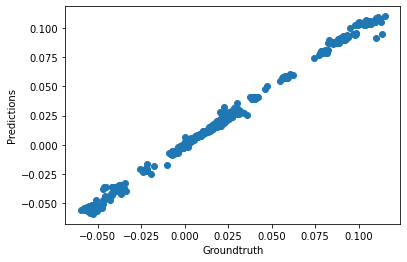

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [58]:
#%store model_fl_com_y

In [59]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [60]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")